In [1]:
library(gridExtra)
library(rstan)
library(splines)
library(matrixStats)
set.seed(123)

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



  |======================================================================| 100%

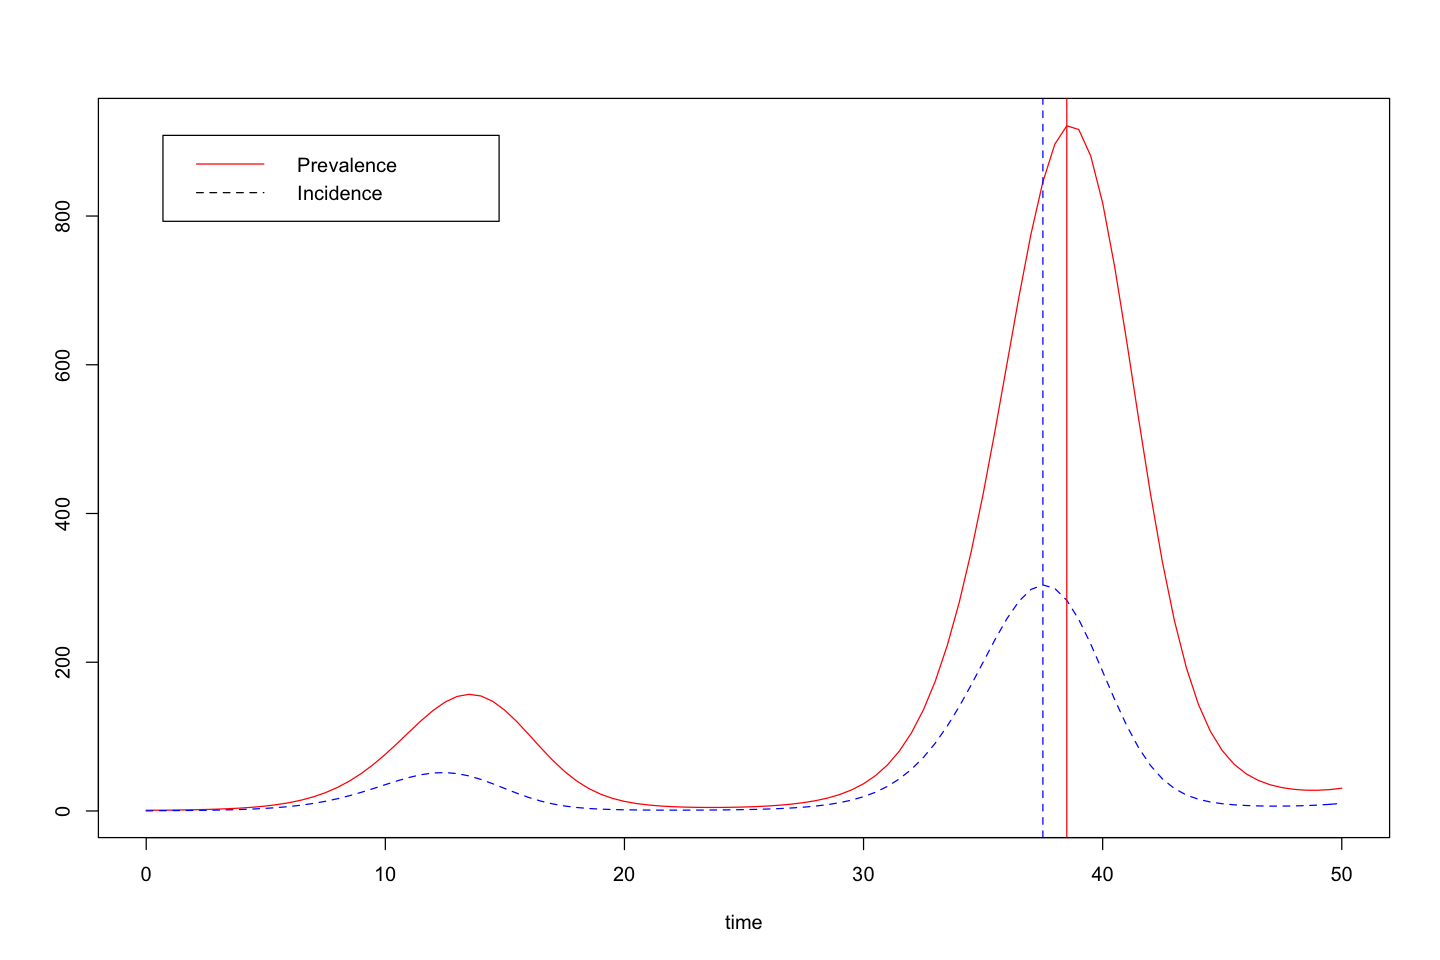

In [2]:
# Simulation length and resolution
dx <- 0.5 # step size
max_time <- 50 # time horizon
xx <- seq(0, max_time, dx) # time grid
nn <- length(xx) 


# Generation distribution
rbase <- function(n) rgamma(n, theta1, theta2)
dbase <- function(n) dgamma(n, theta1, theta2)
pbase <- function(n) pgamma(n, theta1, theta2)

theta1 <- 3
theta2 <- 2

g <- pbase(xx[2:nn]) - pbase(xx[1:(nn-1)]) # precompute generation intervals in the bins
g <- c(g, 1-sum(g)) # ensure sum to 1
G <- 1 - pbase(xx) # survival function


# Time-varying reproduction number
R0 <- 1.3
Rt <- function(x) {
  R0 + sin(0.25*x)
}


# Reproduction number and generation time arrays
A <- matrix(0, nrow=nn, ncol=nn) # init Rt matrix
C <- matrix(NA, nrow=nn, ncol=nn) # init g matrix

for(i in 1:nn){
  A[,i] <- Rt(pmax(0,xx-xx[i])) # populate Rt matrix
  C[i,] <- g  # populate g matrix
}

A[upper.tri(A)] <- 0

A2 = matrix(0,nrow=nn,ncol=nn)
R=Rt(xx)
for(i in 1:nn){
  for(j in 1:i){
    A2[,i] <- R[i-j+1]   
  }  
}


# Initialise prevalence (Bp) and incidence (Bi)
Bi <- Bp <- matrix(0 ,nrow = nn, ncol = nn)

# Prevalence for steps 1 and 2
Bp[,1] <- G[1]
Bp[,2] <- G[2] + C[,(2-1):1] * A[,1:(2-1)] * Bp[,1:(2-1)]

# Incidence for steps 1 and 2
Bi[,1] <- R * g[1] 
Bi[,2] <- R * g[2] + C[,(2-1):1] * A[,1:(2-1)] * Bi[,1:(2-1)] 

# Prev and incidence further steps
pb <- txtProgressBar(min = 0, max = nn, style = 3)
for(i in 3:nn){
  convolution1 <- rowSums(C[,(i-1):1] * A[,1:(i-1)] * Bp[,1:(i-1)], na.rm=T)
  Bp[,i] <- G[i] + convolution1
    
  convolution2 <- rowSums(C[,(i-1):1] * A[,1:(i-1)] * Bi[,1:(i-1)], na.rm=T)
  Bi[,i] <- Rt(xx) * g[i] + convolution2
    
  setTxtProgressBar(pb, i) 
}


# Plot simulated prevalence and incidence for the given Rt
options(repr.plot.width = 12, repr.plot.height = 8)
plot(xx, diag(Bp), type = "l", col = "red", xlab = "time", ylab = "", lty = 1)
lines(xx, diag(Bi), type = "l", col = "blue", lty = 2)
abline(v = xx[which.max(diag(Bp))], col = 'red')
abline(v = xx[which.max(diag(Bi))], col = 'blue', lty = 2)
legend("topleft",
       inset = c(0.05, 0.05),
       legend = c("Prevalence", "Incidence"),
       col = c("red", "black"), 
       lty = 1:2)


In [3]:
# Recover prevalence and incidence via inference with stan

# Add noise to previously simulated prevalence and incidence
x <- xx
n <- length(x)
response_p <- diag(Bp) + rnorm(n, 0, 0.4 * diag(Bp))
response_i <- diag(Bi) + rnorm(n, 0, 0.4 * diag(Bi))

# Spline basis specification
b <- 10
Basis <- bs(x, df=b, degree=3)


# Stan
options(mc.cores = parallel::detectCores())
rstan_options("auto_write" = FALSE)

m_prev_inc_ll <- stan_model("../stan/prevalence_incidence_likelihood.stan")
m_prev_ll <- stan_model("../stan/prevalence_likelihood.stan")

stan_data <- list(N = n,
                 prev = ceiling(response_p),
                 inc = ceiling(response_i),
                 g = g,
                 G = G,
                 C = C,
                 x = x,
                 Basis = Basis,
                 B = b,
                 threshold = 50)

fit_prev_inc_ll <- optimizing(m_prev_inc_ll, 
                  data = stan_data, 
                  hessian = TRUE, 
                  draws = 1000, 
                  verbose = TRUE, 
                  algorithm = "LBFGS")

fit_prev_ll <- optimizing(m_prev_ll, 
                   data = stan_data, 
                   hessian = TRUE, 
                   draws = 1000,
                   verbose = TRUE,
                   algorithm = "LBFGS")

Chain 1: Initial log joint probability = -118076
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1: Exception: multiply: A[2142] is nan, but must not be nan!  (in 'model58b32fda3d82_prevalence_incidence_likelihood' at line 56)

Exception: multiply: A[3264] is nan, but must not be nan!  (in 'model58b32fda3d82_prevalence_incidence_likelihood' at line 58)

Exception: multiply: A[6426] is nan, but must not be nan!  (in 'model58b32fda3d82_prevalence_incidence_likelihood' at line 58)


Chain 1:       19       94303.3     0.0703979        7676.6      0.2671           1       36   
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:       39       97064.4     0.0934548       4276.99           1           1       57   
Chain 1:     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Chain 1:       59       97409.2     0.0277334       1393.61   

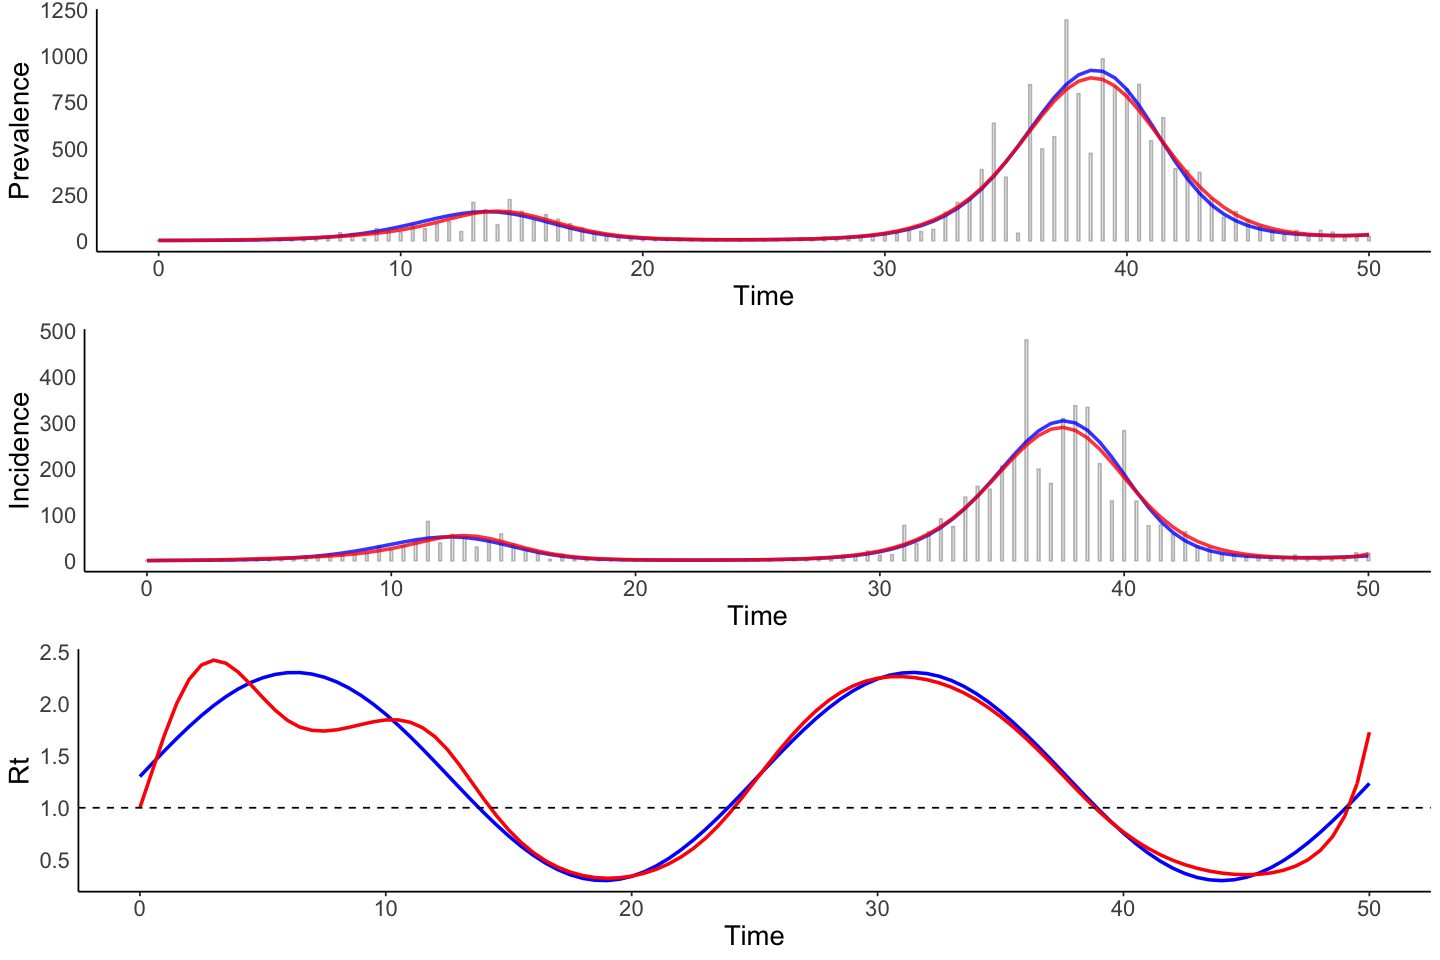

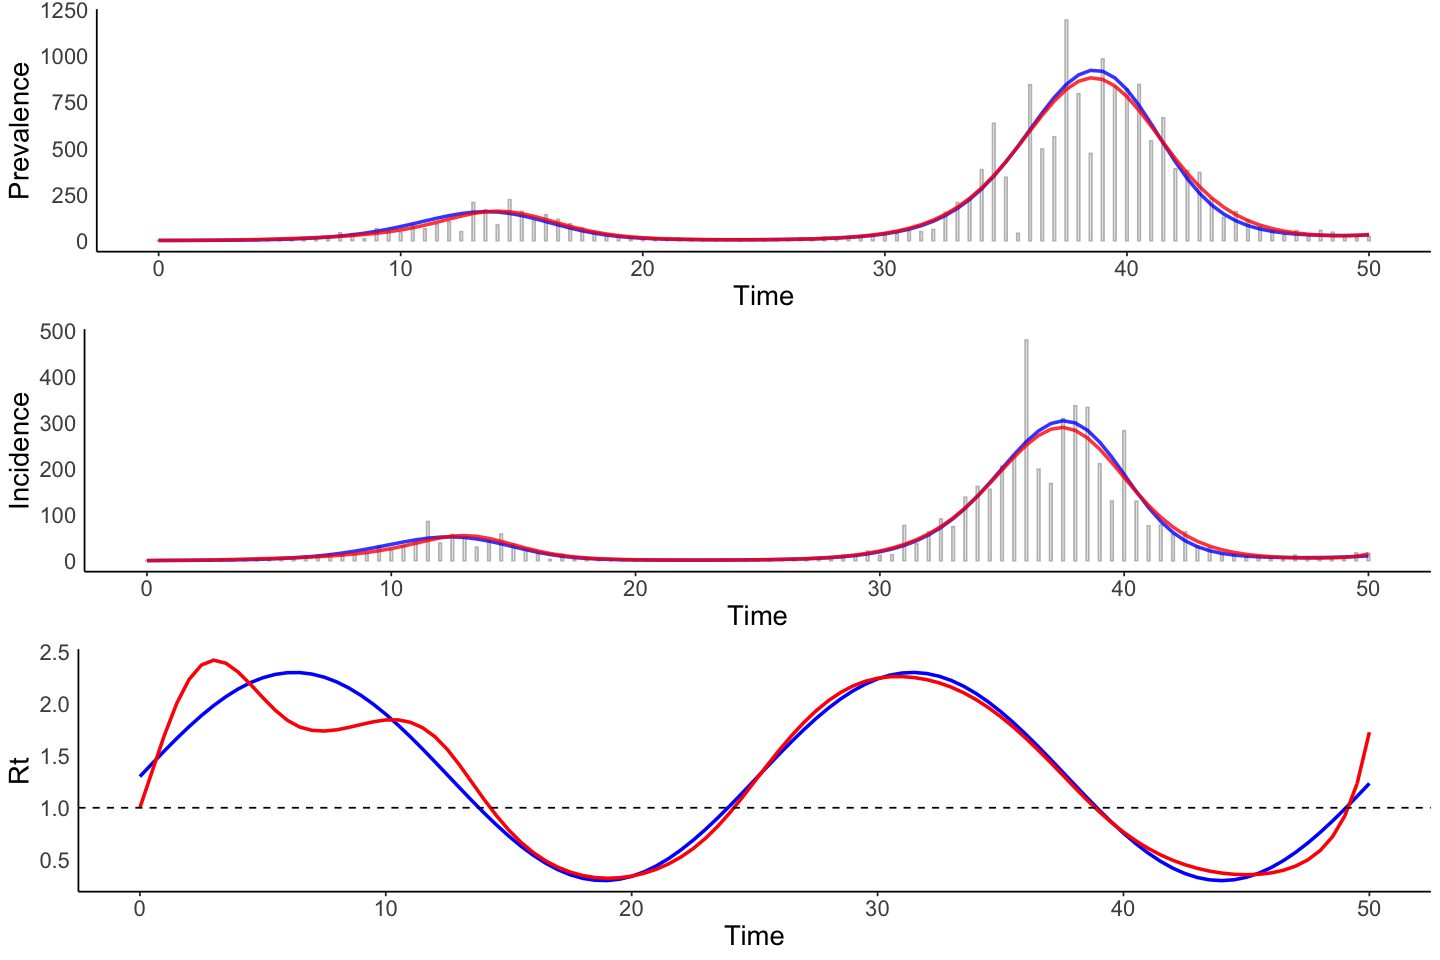

In [7]:
# Extract prevalence/incidence/Rt draws
draws_prev_inc_ll <- list()
draws_prev_inc_ll$prev <- fit_prev_inc_ll$theta_tilde[,grep('output1', names(fit_prev_inc_ll$par))]
draws_prev_inc_ll$inc <- fit_prev_inc_ll$theta_tilde[,grep('output2', names(fit_prev_inc_ll$par))]
draws_prev_inc_ll$rt <- fit_prev_inc_ll$theta_tilde[,grep('output3', names(fit_prev_inc_ll$par))]

draws_prev_ll <- list()
draws_prev_ll$prev <- fit_prev_ll$theta_tilde[,grep('output1', names(fit_prev_ll$par))]
draws_prev_ll$inc <- fit_prev_ll$theta_tilde[,grep('output2', names(fit_prev_ll$par))]
draws_prev_ll$rt <- fit_prev_ll$theta_tilde[,grep('output3', names(fit_prev_ll$par))]


# Reproduce fig2
g_prev <- ggplot() +
  geom_bar(data = data.frame(x = x, y = response_p), 
           aes(x, y), 
           color = "gray", 
           fill = "white", 
           stat="Identity", 
           alpha = 0.8, 
           width = 0.1) + 
  geom_line(data = data.frame(x = xx, y = diag(Bp)), 
            aes(x, y), 
            color = "blue", 
            size = 1, 
            alpha = 0.8) +
  geom_line(data = data.frame(x = x, y = colMeans(draws_prev_inc_ll$prev)),
            aes(x, y), 
            color="red",
            size=1, 
            alpha = 0.8) +
  xlab("Time") +
  ylab("Prevalence") +
  theme_classic() +
  theme(axis.ticks.y = element_blank()) +
  theme(axis.text.y = element_text(size=rel(1.5))) +
  theme(axis.text.x = element_text(size=rel(1.5))) +
  theme(axis.title = element_text(size=rel(1.5)))

g_inc <- ggplot() +
  geom_bar(data=data.frame(x = x, y = response_i),
           aes(x,y),
           color='gray',
           fill="white",
           stat='Identity',
           alpha=0.8,
           width=0.1) +
  geom_line(data=data.frame(x = xx, y = diag(Bi)),
            aes(x,y),
            color = "blue",
            size = 1, 
            alpha = 0.8) +
  geom_line(data = data.frame(x = x, y = colMeans(draws_prev_inc_ll$inc)),
            aes(x, y),color = "red", 
            size=1,
            alpha=0.8) +
  xlab("Time") +
  ylab("Incidence") +
  theme_classic() +
  theme(axis.ticks.y = element_blank()) +
  theme(axis.text.y = element_text(size = rel(1.5))) +
  theme(axis.text.x = element_text(size = rel(1.5))) +
  theme(axis.title = element_text(size = rel(1.5)))

g_rt <- ggplot() +
  geom_line(data=data.frame(x = x, y = Rt(x)),
            aes(x, y), 
            color = "blue",
            size = 1) +
  geom_line(data = data.frame(x = x, y = (colMeans(draws_prev_inc_ll$rt)[1:n])),
            aes(x,y),
            color = 'red',
            size = 1) +
  geom_hline(yintercept = 1, linetype = "dashed")+
  xlab("Time")+
  ylab("Rt")+
  theme_classic()+
  theme(axis.ticks.y = element_blank())+
  theme(axis.text.y = element_text(size=rel(1.5)))+
  theme(axis.text.x = element_text(size=rel(1.5)))+
  theme(axis.title = element_text(size=rel(1.5)))

options(repr.plot.width = 12, repr.plot.height = 8)
grid.arrange(g_prev, g_inc, g_rt)

ggsave('../figures/Figure2_BH.pdf', 
       grid.arrange(g_prev, g_inc, g_rt), 
       width = 10, 
       height = 6)

In [6]:
# Compare the fit using the prevalence likelihood to jointly
# using prevalence and incidence likelihoods 
data.frame(
    
  "Model" = c("Prevalence+incidence likelihood", "Prevalence likelihood"),
  "Prevalence MSE" = c(mean((colMeans(draws_prev_inc_ll$prev) - diag(Bp))^2 ), 
                       mean((colMeans(draws_prev_ll$prev) - diag(Bp))^2 )),

  "Incidence MSE" = c(mean((colMeans(draws_prev_inc_ll$inc) - diag(Bi))^2 ), 
                      mean((colMeans(draws_prev_ll$inc) - diag(Bi))^2 )),

  "Rt MSE" = c(mean((colMeans(draws_prev_inc_ll$rt) - Rt(x))^2 ), 
               mean((colMeans(draws_prev_ll$rt) - Rt(x))^2 ))
    
)

Model,Prevalence.MSE,Incidence.MSE,Rt.MSE
<chr>,<dbl>,<dbl>,<dbl>
Prevalence+incidence likelihood,222.6582,29.41868,0.03424173
Prevalence likelihood,426.1110,53.95638,0.05312560
